In [1]:
#https://github.com/gboeing/osmnx-examples/blob/master/notebooks/13-isolines-isochrones.ipynb
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon
%matplotlib inline
ox.config(log_console=True, use_cache=True)
ox.__version__

## to assess time script takes to run, for 1 iteration
import time
start_time = time.time()

In [2]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': list(subgraph.nodes)}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

In [3]:
# configure the network type, trip times, and travel speed
network_type = 'drive'
trip_times = [5, 10, 15, 20, 25] #in minutes
travel_speed = 48.28 #walking speed in km/hour (30 mph)
dist = 24140 ## in meters (10 miles)

# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0, return_hex=True)

In [4]:
hospitals = pd.read_csv("data/nj_hospitals.csv", low_memory = False)

[25, 20, 15, 10, 5]


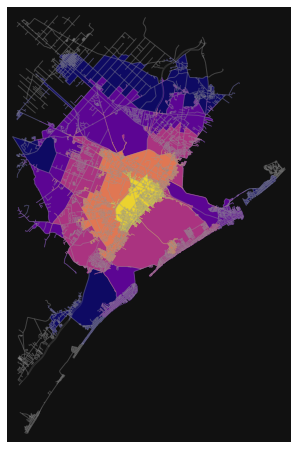

In [5]:
## !!! for running process once !!!!
import numpy as np
x = np.arange(0,1)
for i in x:

#for i in range(len(hospitals)):

    lat = hospitals.iloc[i,5]
    long = hospitals.iloc[i,6]
    er_name = hospitals.iloc[i,8]

    # configure the place
    place = (lat, long)
    
    # download the street network
    G = ox.graph_from_point(place, dist=dist, network_type='drive')
    
    # find the centermost node and then project the graph to UTM
    gdf_nodes = ox.graph_to_gdfs(G, edges=False)
    x, y = gdf_nodes['geometry'].unary_union.centroid.xy
    center_node = ox.get_nearest_node(G, (y[0], x[0]))
    G = ox.project_graph(G)
    
    # add an edge attribute for time in minutes required to traverse each edge
    meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
    for u, v, k, data in G.edges(data=True, keys=True):
        data['time'] = data['length'] / meters_per_minute
    
    isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)
    fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='#999999', edge_alpha=0.2, node_size=0)
    for polygon, fc in zip(isochrone_polys, iso_colors):
        patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.7, zorder=-1)
        ax.add_patch(patch)   
        
    trip_times.sort(reverse=True)
    print(trip_times)
    
    poly_df = gpd.GeoDataFrame(zip(isochrone_polys,iso_colors, trip_times), columns = ['geometry', 'color', 'drivetime'], crs="EPSG:26918")
    poly_df['ER'] = er_name
    
    filename = "gis_data/isochrones/" + er_name + ".json"
    poly_df.to_file(filename, driver="GeoJSON")

In [6]:
print((time.time() - start_time)/60, "minutes")

3.5550040721893312 minutes
